## Notebook

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pprint import pprint

## Configuracja

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 9)

from radon import * # dziala jak biblioteka
# mozna sobie z funkcji wszystko zbudowac
# ponizej pare przykladow

# tak wygladaja parametry jakie mozemy konfigurowac
CONFIG = {
    "path": "data/Shepp_logan.jpg",
    "shape": (600, 600),
    "alpha": 0.5,
    "rays": 2000,
    "l": None,
    "filtered": True,
}

## Pipeline

In [1]:
def do_algorithm():
    global CONFIG
    
    img = fn_load(CONFIG["path"])
    CONFIG = fn_autoparam(CONFIG, img.shape)
    pprint(CONFIG)
    
    print("[1 step] img -> sinogram (~3 sec)")
    sinogram, lines = fn_tomograph(img, alpha=CONFIG["alpha"], rays=CONFIG["rays"], l=CONFIG["l"])

    print("[2 step] sinogram -> img (~3 sec)")
    ctimg = fn_fbp(img.shape, sinogram, lines, filtered=CONFIG["filtered"], n_slices = 6)

    print("[3 step] processing")
    ctimg_clip = fn_clip(ctimg[-1], agressive=CONFIG["filtered"])
        
    plt.subplot(1, 3, 1), plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.subplot(1, 3, 2), plt.imshow(sinogram)
    plt.xticks([]), plt.yticks([])
    plt.subplot(1, 3, 3), plt.imshow(ctimg_clip)
    plt.xticks([]), plt.yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    print(f"RMSE={fn_calc_rmse(ctimg_clip, img)}")
    
    for _ in ctimg:
        plt.figure()
        plt.imshow(fn_clip(_))

## Demo

interactive(children=(Dropdown(description='path', options=('data/Shepp_logan.jpg', 'data/CT_ScoutView.jpg', '…

{'alpha': 0.5,
 'filtered': True,
 'l': 636.6197723675814,
 'path': 'data/Shepp_logan.jpg',
 'rays': 2000,
 'shape': (600, 600)}
[1 step] img -> sinogram (~3 sec)
[2 step] sinogram -> img (~3 sec)
[3 step] processing


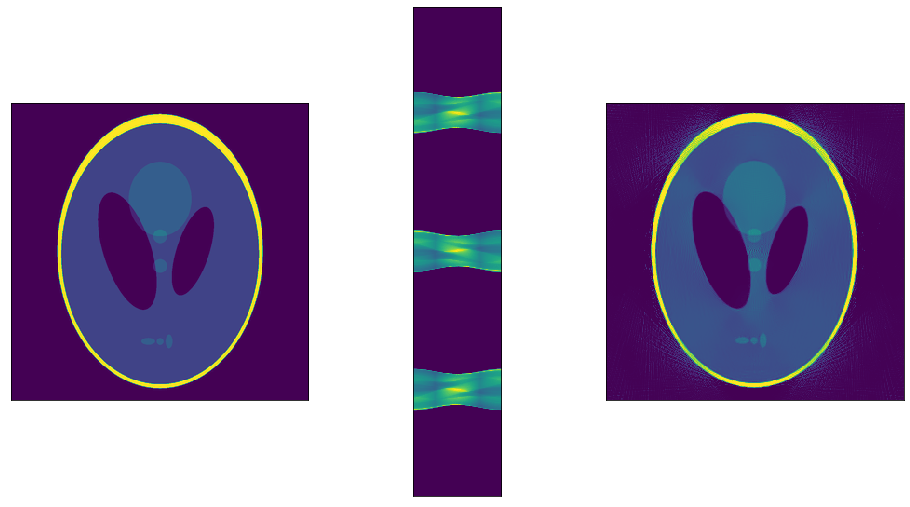

RMSE=0.09404230849869698


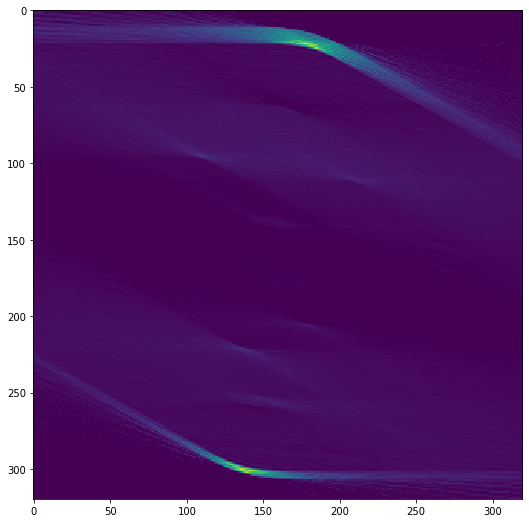

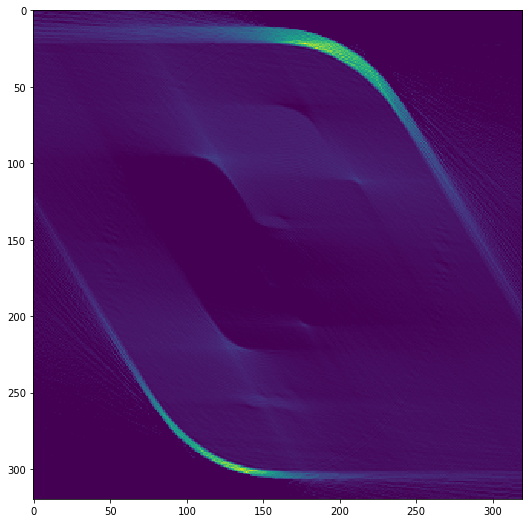

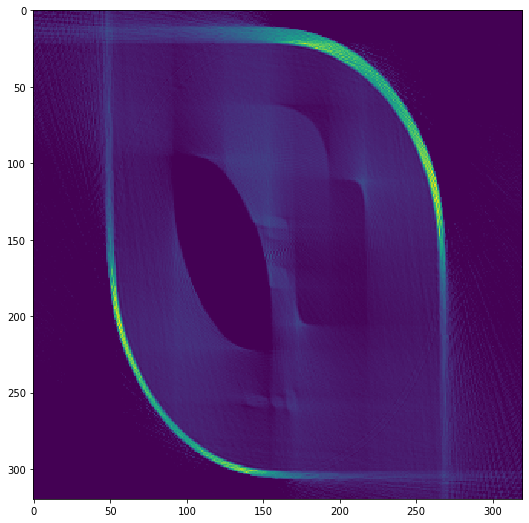

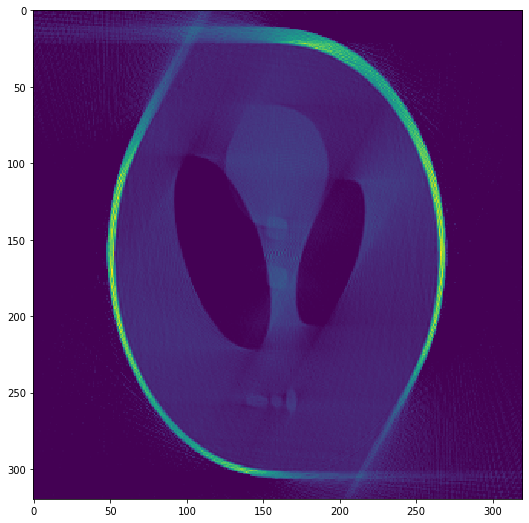

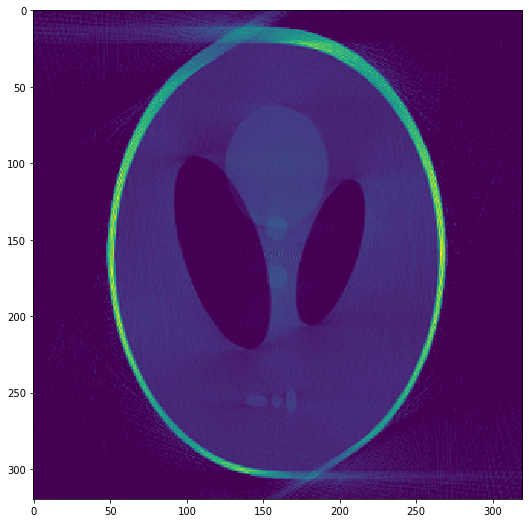

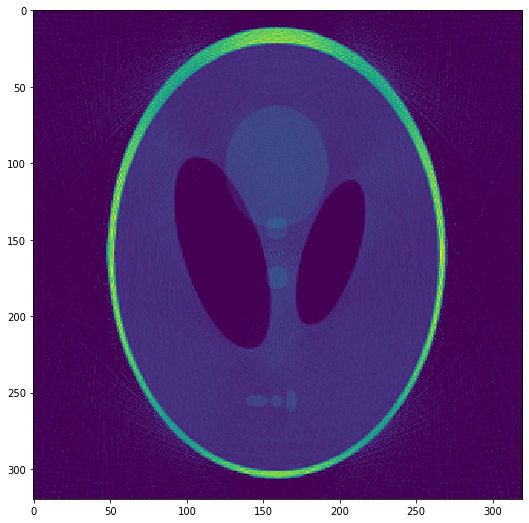

In [5]:
def set_ipython(path=None, alpha=None, rays=None, l=None, filtered=None):
    global CONFIG
    if path is not None:
        CONFIG["path"] = path
    if alpha is not None:
        CONFIG["alpha"] = alpha
    if rays is not None:
        CONFIG["rays"] = rays
    if l is not None:
        CONFIG["l"] = l
    if filtered is not None:
        CONFIG["filtered"] = filtered
    do_algorithm()
    
# XXX: l == 0 oznacza ze sam ma sobie wybrac ta WARTOSC (autoparam)!
interact_manual(set_ipython, filtered=True,\
        path=["data/Shepp_logan.jpg", "data/CT_ScoutView.jpg", "data/Kwadraty2.jpg"], \
        alpha=widgets.FloatSlider(min=0.1, max=10, step=0.5, value=0.5, title="Krok ∆α układu emiter/detektor."), \
        rays=widgets.IntSlider(min=1, max=2000, step=1, value=2000, title="Liczbę detektorów (n)."), \
        l=widgets.IntSlider(min=0, max=2000, step=1, value=0, title="Rozwartość/rozpiętość układu emiter/detektor (l)."));

do_algorithm()

## DICOM

In [6]:
def do_dicom(PatientName=None, ImageComments=None, StudyDate=None):
    fn_save_dicom(
            "data/test.dcm",
            data={
                "PatientName": PatientName,
                "ImageComments": ImageComments,
                "StudyDate": StudyDate,
            },
        )

    # tutaj laduje i wyswietla dane z pliku (prefix "===")
    img = fn_load_dicom("data/test.dcm")

    plt.figure()
    plt.imshow(img)
    
interact_manual(do_dicom, \
        PatientName="Maciej A. Czyzewski", \
        ImageComments="Obrazek testowy, prawda?", \
        StudyDate="20200119")

interactive(children=(Text(value='Maciej A. Czyzewski', description='PatientName'), Text(value='Obrazek testow…

<function __main__.do_dicom(PatientName=None, ImageComments=None, StudyDate=None)>

## Bonus (jak dziala filtr)

moja symulacja dziala tak:<br>
<img src="docs/detector_cone.gif" />

mozna jednak zauwazyc ze jak dodamy piksele na liniach mamy taki efekt:<br>
<img src="docs/fbp_problem.gif"  />

poniewaz sytuacja wyglada nastepujaco:<br>
<img src="docs/fbp_problem_fft.png" width="200px"  />

zastosowalem wiec klasyczne rozwiazanie:<br>
<img src="docs/fbp_pipeline.png" width="400px"  />

dlatego udalo sie mi zblizyc do dosc dobrej jakosci (orginal):<br>
<img src="docs/test_file.png" />

moje otworzenie:<br>
<img src="docs/test_radon.png" />

moje otworzenie bez filtra (fft)<br>
<img src="docs/test_radon_without.png" width="600px" />